In [554]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [555]:
def f(x):
    return 6 - 13 * x - 5 * x ** 2 - 4 * x ** 3

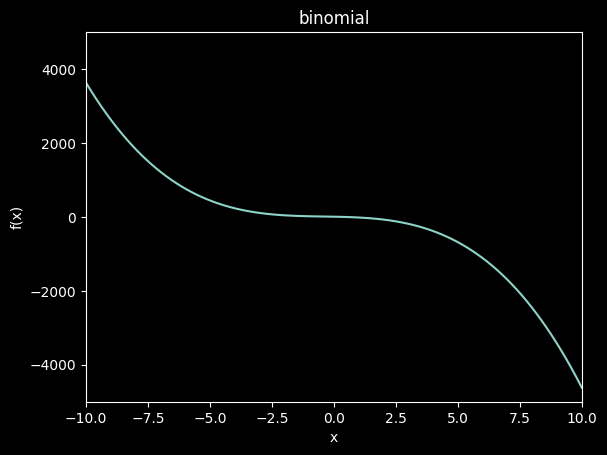

In [556]:
dots = np.linspace(-10, 10, 100)
plt.title('binomial')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10, 10)
plt.plot(dots, f(dots))
plt.show()

In [557]:
# min bias, max variance
x_datas = []
f_datas = []

for i in range(10):
    x_data = np.random.uniform(-10, 10, 20)
    x_datas.append(x_data)
    f_datas.append([f(i) for i in x_data] + np.random.uniform(-500, 500, 20))

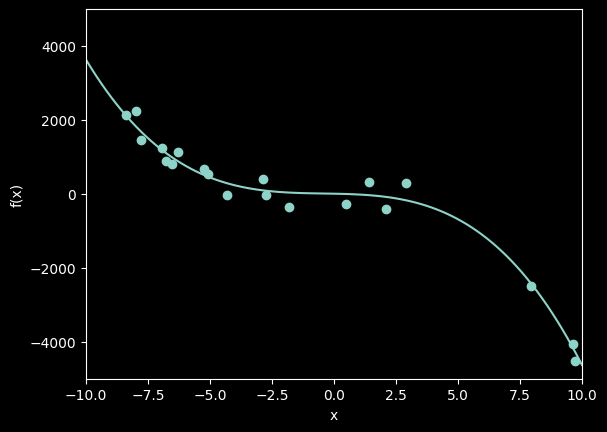

In [558]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10, 10)
plt.plot(dots, f(dots))
plt.scatter(x_datas[5], f_datas[5])  # for example 5 iter
plt.show()

In [559]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [560]:
regressors = []
for i in range(10):
    # create model
    regressor = DecisionTreeRegressor(random_state=10, max_depth=10)
    regressor.fit(np.reshape(x_datas[i], (-1, 1)), f_datas[i])
    regressors.append(regressor)

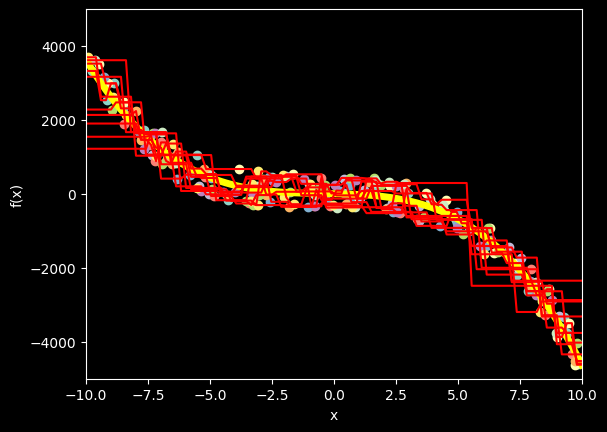

In [561]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10, 10)

predictions = []
plt.plot(dots, f(dots), c='yellow', linewidth=5)
for i in range(10):
    plt.scatter(x_datas[i], f_datas[i])
    prediction = regressors[i].predict(np.reshape(dots, (-1, 1)))
    predictions.append(prediction)
    plt.plot(dots, prediction, c='r')
predictions = np.array(predictions)

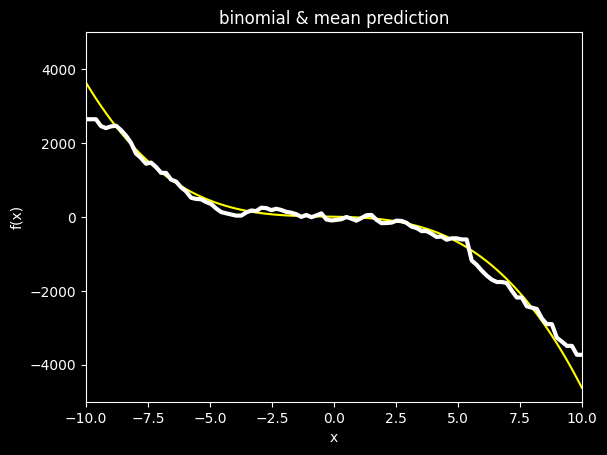

In [562]:
mean_prediction = np.mean(predictions, axis=0)

plt.xlim(-10, 10)
plt.ylim(-5000, 5000)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('binomial & mean prediction')
plt.plot(dots, f(dots), c='yellow')
plt.plot(dots, mean_prediction, c='w', linewidth=3)

plt.show()

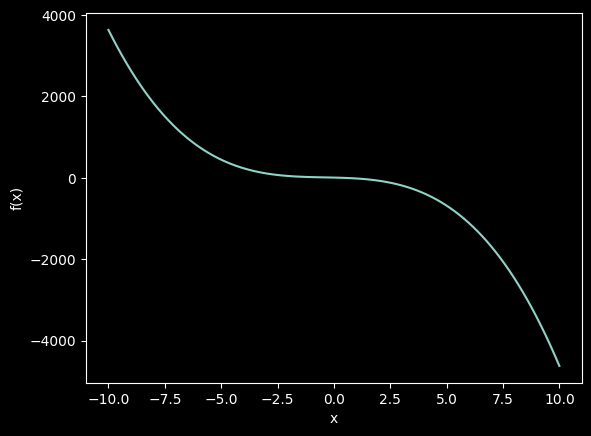

In [563]:
# Max bias, min variance
plt.xlabel('x')
plt.ylabel('f(x)')
plt.plot(dots, f(dots))
plt.show()

In [564]:
regressors = []

for i in range(10):
    regressor = LinearRegression()

    regressor.fit(np.reshape(x_datas[i], (-1, 1)), f_datas[i])
    regressors.append(regressor)

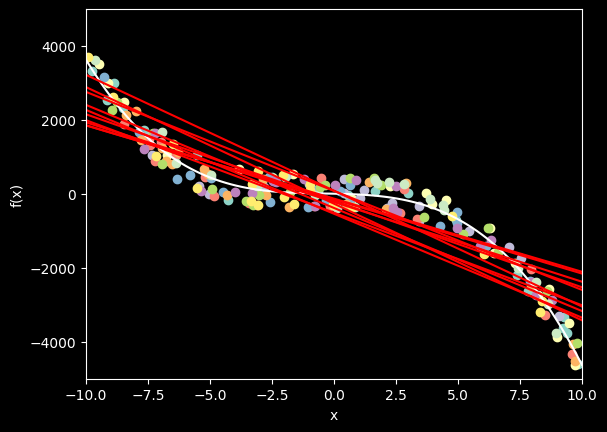

In [565]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10, 10)

plt.plot(dots, f(dots), c='w')
predictions = []
for i in range(10):
    plt.scatter(x_datas[i], f_datas[i])
    prediction = regressors[i].predict(np.reshape(dots, (-1, 1)))
    predictions.append(prediction)
    plt.plot(dots, prediction, c='r')

plt.show()

predictions = np.array(predictions)

In [566]:
mean_prediction = np.mean(predictions, axis=0)

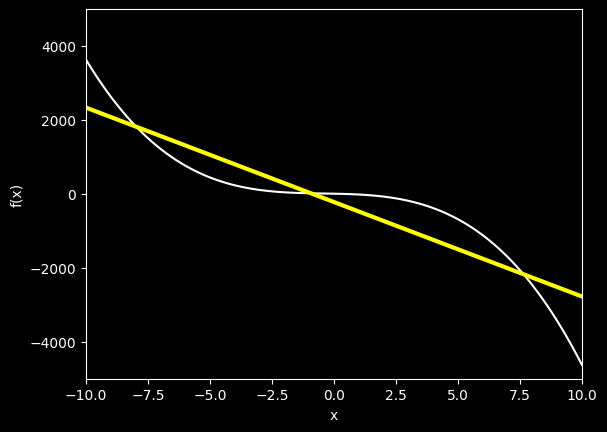

In [567]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim(-10, 10)
plt.ylim(-5000, 5000)

plt.plot(dots, f(dots), c='w')
plt.plot(dots, mean_prediction, c='yellow', linewidth='3')
plt.show()

In [568]:
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

In [569]:
classification_data, classification_labels = make_classification(n_samples=500,
                                                                 n_features=5, n_informative=5,
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=23)

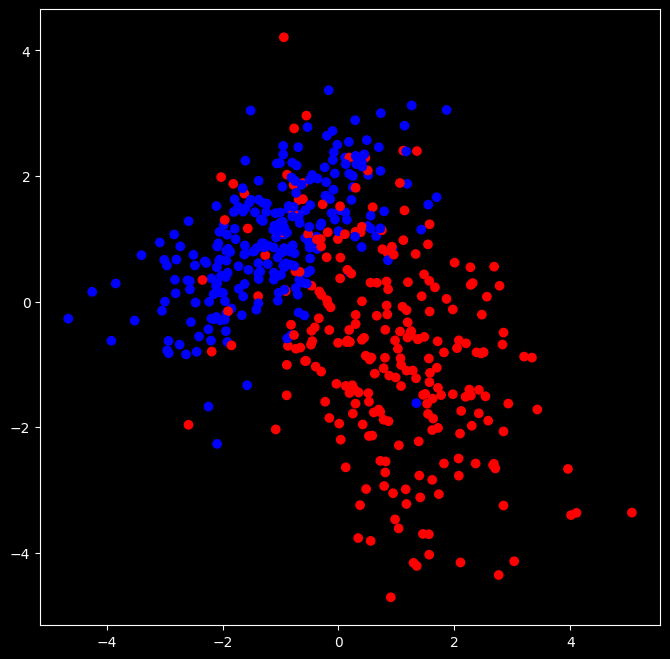

In [570]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8, 8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], c=classification_labels, cmap=colors)
plt.show()

In [571]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]  # 500
    bootstrap = []

    for i in range(N):
        # random select samples => len(random_samples) == len(samples)
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]  # i-iter => select data of random samples
        b_labels = labels[sample_index] # i-iter => random labels

        bootstrap.append((b_data, b_labels))

    return bootstrap

In [572]:
#get_bootstrap(classification_data, classification_labels, 2)

In [573]:
# for classification => m = np.sqrt(len(samples))
def get_subsample(len_sample):
    sample_indexes = list(range(len_sample))  # save index samples
    len_subsample = int(np.round(np.sqrt(len_sample)))
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [574]:
get_subsample(36)

array([35, 13, 26, 30, 16, 31])

In [575]:
# create tree
class Node:
    def __init__(self, index, t, left_branch, right_branch):
        self.index = index
        self.t = t
        self.left_branch = left_branch
        self.right_branch = right_branch

In [576]:
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()


    def predict(self):
        classes = {}

        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        # find max class in Leaf & return his
        prediction = max(classes, key=classes.get)
        return prediction

In [577]:
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    impurity = 1

    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity

In [578]:
def gain(left_labels, right_labels, root_criterion):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    gain_result = root_criterion - p * gini(left_labels) - (1 - p) * gini(right_labels)

    return gain_result

In [579]:
# split dataset in Node
def split(data, labels, column_index, t):
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)

    true_data = data[left]
    false_data = data[right]

    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [580]:
def find_best_split(data, labels):
    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    feature_subsample_indices = get_subsample(n_features)

    for index in feature_subsample_indices:
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            current_gain = gain(true_labels, false_labels, root_gini)

            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t , index

    return best_gain, best_t, best_index

In [581]:
def build_tree(data, labels):
    gain, t, index = find_best_split(data, labels)

    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    left_branch = build_tree(true_data, true_labels)
    right_branch = build_tree(false_data, false_labels)

    return Node(index, t, left_branch, right_branch)

In [582]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))

    return forest

In [583]:
def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.left_branch)
    else:
        return classify_object(obj, node.right_branch)

In [584]:
def predict(data, tree):

    classes = []

    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)

    return classes

In [585]:
def tree_vote(forest, data):

    predictions = []

    for tree in forest:
        predictions.append(predict(data, tree))

        predictions_per_object = list(zip(*predictions))

        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

        return voted_predictions

In [586]:
from sklearn.model_selection import train_test_split

In [587]:
train_data, test_data, train_labels, test_labels = train_test_split(classification_data,
                                                                    classification_labels,
                                                                    test_size=0.3,
                                                                    random_state=1)

In [588]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [589]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

In [591]:
train_answers = tree_vote(my_forest_1, train_data)

In [592]:
test_answers = tree_vote(my_forest_1, test_data)

In [594]:
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'{train_accuracy:.3f}')

93.143


In [595]:
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'{test_accuracy:.3f}')

83.333


In [597]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

In [599]:
train_answers = tree_vote(my_forest_3, train_data)

In [601]:
test_answers = tree_vote(my_forest_3, test_data)

In [602]:
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'{train_accuracy:.3f}')

96.000


In [603]:
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'{test_accuracy:.3f}')

91.333


In [604]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

In [605]:
train_answers = tree_vote(my_forest_10, train_data)

In [606]:
test_answers = tree_vote(my_forest_10, test_data)

In [607]:
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'{train_accuracy:.3f}')

95.143


In [608]:
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'{test_accuracy:.3f}')

80.000


In [609]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

In [610]:
train_answers = tree_vote(my_forest_50, train_data)

In [611]:
test_answers = tree_vote(my_forest_50, test_data)

In [613]:
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'{train_accuracy:.3f}')

97.429


In [614]:
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'{test_accuracy:.3f}')

90.667
